# <center>量化金融 python 实践 3- 价差交易工具介绍</center>


## Veighna Trader 介绍
Veighna Trader 是 Github上大名鼎鼎的python开源量化框架，前身也叫VNPY，工具好坏由各位看官自行判断，这里直接入正题讲讲如何使用。


官方documentation给出了一部分的教程，(https://www.vnpy.com/docs/cn/index.html)

位于首页的使用文档 - SpreadTrading多合约价差套利模块

这里在官网基础上再做一些延申。

启动Veighna Station后，以模拟交易为例，可以勾选CTP测试，使用ctp官方Simnow模拟账户进行。

但是Simnow时不时会进行服务器维护，对日常使用难免产生影响，因此笔者这里选择勾选Openctp新开发的TTS接口。

<img src="1.png" width=600>

点击启动进入。



初次使用需要进行两步操作，

- 在openctp 公众号申请账户（免费）
- 如果是仿真模拟，需要用 veighna_studio/Lib/site-packages/vnpy_ctp/api 文件夹下的thostmduserapi_se dll文件替换 veighna_studio/Lib/site-packages/vnpy_tts/api 文件夹下的同名dll文件。
- 如果是7*24模拟，无需替换dll。

有了以上两步，点击系统 - 连接TTS

出现下图，这里就体现TTS一个好处，需要填写的信息比Simnow少一些。

<img src="2_1.png" width=250>

只要按要求填入
- 用户名、
- 密码、
- 交易服务器、
- 行情服务器,  

然后点击连接。

用户名密码从公众众号获取，交易服务器和行情服务器地址需要从openctp github项目地址内获取。

以上连接TTS创建的信息会被保存至C盘 C:\Users\Administrator(用户名)\\.vntrader\connect_tts.json文件中

<img src="3_1.png" width=400>

回到Veighna Trader主界面，点击左上角的价差按钮，如下图所示，进入价差交易界面

<img src="4.png" width=40>

价差交易界面

<img src="5.png" width=1000>




首先要点击主界面左下角的 [创建价差] 按钮

以豆粕菜粕1：1价差组合为例，


<img src="6.png" width=350>  

这里要提到的一点是主动腿代码，一般选择组合内相对流动性最差的标的物。

因为价差组合交易，发单顺序是先发主动腿合约，主动腿合约成交之内，立刻以对手价成交被动腿合约，所以被动腿合约的流动性必须足够好。

剩余部分请参考官方文档说明，此处不做赘述。



如果每次创建价差，都需要在方框内挨个输入信息，操作过于不便。

在C盘 C:\Users\Administrator(用户名)\\.vntrader\spread_trading_setting.json 文件内可以直接修改或者复制增加价差组。

如下所示


In [ ]:
# 以json格式储存的价差组信息
[
    {
        "name": "m01_RM01", # 价差名称
        "leg_settings": [
            {
                "variable": "A", # 变量名
                "vt_symbol": "m2401.DCE", # 标的物代码, 注意不同交易所之间的代码大小写
                "trading_direction": 1, # 交易方向，1为做空，-1为做空
                "trading_multiplier": 1 # 交易乘数，正负号和交易方向保持一致
            },
            {
                "variable": "B",
                "vt_symbol": "RM401.CZCE",
                "trading_direction": -1,
                "trading_multiplier": -1
            }
        ],
        "price_formula": "A-B", 
        "active_symbol": "m2401.DCE", #主动腿代码
        "min_volume": 1.0
    }
]

回到价差交易界面，左上角部分是手动交易区域，需填写：
- 价差组合名称,
- 方向,
- 价格,
- 超价：以超过目标价格X的数量发出交易指令。设置到参数是为了在一定容忍度范围内，尽可能保证成交。
- 间隔：由于系统默认的方式是发出主动腿限价单，有时候即使出现价差没有变化，但是标的物价格大幅移动的情况。因此，设置间隔N秒的形式去刷新未成交挂单。

点击启动，算法就会开始工作。

<img src="7.png" width=200>


手动交易发出的挂单，可以通过双击算法框内挂单撤销。

<img src="8.png" width=500>

# 自动化交易
Veighna Trader 作为一款量化交易平台，单纯的手动交易是无法满足使用者需求的。

交易界面的左下角是自动化价差交易策略的加载点。Veighna自带两个价差交易策略。

- BasicSpreadStrategy

- StatisticalArbitrageStrategy

## BasicSpreadStrategy

BasicSpreadStrategy允许使用者输入买开，卖平，卖开，买平四个价格参数，分别对应策略参数 buy_price, sell_price, short_price, cover price.

这四个价格参数关系如下所示，当价格低于买开阈值则开价差组合多仓，高于卖开阈值则开价差组合空仓。

<img src="9.png" width=400>

这些价格参数完全由交易员自行设置，该策略更偏向于半自动化交易。




## StatisticalArbitrageStrategy 介绍

StatisticalArbitrageStrategy 是一个完全教科书级别的价差交易策略。

大部分的量化金融基础教材上，对于价差交易的描述，是假定价差组合是一个平稳序列分布，即当价差触碰上限阈值时做空，触碰下限阈值时做多。

Veighna提供的该套利策略，利用布尔(boll)指标，即计算过去N日的价差均值$\mu$和标准差$\sigma$，以$\mu$ + x\* $\sigma$为上限阈值，以$\mu$ - x\* $\sigma$为下限阈值进行操作。x为常数，用来表示距离均线x个标准差。


## StatisticalArbitrageStrategy 历史回测

使用Veighna框架进行历史回测之前，需要先将回测标的物导入到数据库中，

Veighna提供多种数据下载方式，笔者最常用的是官方推荐的米筐数据库。

这里为了保证本节内容的可重复性，笔者会在github附上本节相应的csv数据文件，如果数据库内还没有标的物历史数据，运行以下程序将csv数据添加到数据库中，此处数据库使用默认的sqlite。

In [ ]:
# csv module
from vnpy.trader.utility import ZoneInfo
from vnpy.trader.database import get_database
from vnpy.trader.object import BarData
from vnpy.trader.constant import Exchange, Interval

# 用CSV读取数据并写入数据库
from datetime import datetime, timezone
from csv import DictReader

database = get_database()
tz = ZoneInfo("Asia/Shanghai")
BEIJING_timezone = pytz.timezone('Asia/Shanghai') 
file_names = ["m2305.DCE.csv", "RM305.CZCE.csv"]
for file in file_names:
    with open(file) as f:
        reader = DictReader(f)
        bars = []
        symbol = file.split(".")[0]
        exchange = file.split(".")[1]
        for row in reader:
            dt = datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
            bar = BarData(
                symbol=symbol,
                exchange=Exchange(exchange),
                datetime=BEIJING_timezone.localize(dt),
                interval=Interval.MINUTE,
                open_price=float(row["open"]),
                high_price=float(row["high"]),
                low_price=float(row["low"]),
                close_price=float(row["close"]),
                volume=float(row["volume"]),
                open_interest=float(row["open_interest"]),
                gateway_name="DB"
            )
            bars.append(bar)
        database.save_bar_data(bars)


2023-09-22 13:48:38.109252	开始加载历史数据
2023-09-22 13:48:49.116225	历史数据加载完成，数据量：82995
2023-09-22 13:48:49.155166	策略初始化完成
2023-09-22 13:48:49.155166	开始回放历史数据
2023-09-22 13:48:51.494166	历史数据回放结束
2023-09-22 13:48:51.494166	开始计算逐日盯市盈亏
2023-09-22 13:48:51.505691	逐日盯市盈亏计算完成
2023-09-22 13:48:51.505691	开始计算策略统计指标
2023-09-22 13:48:51.512251	------------------------------
2023-09-22 13:48:51.512251	首个交易日：	2022-06-01
2023-09-22 13:48:51.512251	最后交易日：	2023-05-17
2023-09-22 13:48:51.512251	总交易日：	234
2023-09-22 13:48:51.512251	盈利交易日：	80
2023-09-22 13:48:51.512251	亏损交易日：	67
2023-09-22 13:48:51.512251	起始资金：	1,000,000.00
2023-09-22 13:48:51.512251	结束资金：	1,099,142.76
2023-09-22 13:48:51.512251	总收益率：	9.91%
2023-09-22 13:48:51.512251	年化收益：	10.17%
2023-09-22 13:48:51.512251	最大回撤: 	-47,600.00
2023-09-22 13:48:51.512251	百分比最大回撤: -4.41%
2023-09-22 13:48:51.512251	最长回撤天数: 	3
2023-09-22 13:48:51.512251	总盈亏：	99,142.76
2023-09-22 13:48:51.512251	总手续费：	6,857.24
2023-09-22 13:48:51.512251	总滑点：	10,400.00
2023-09-22 13:4

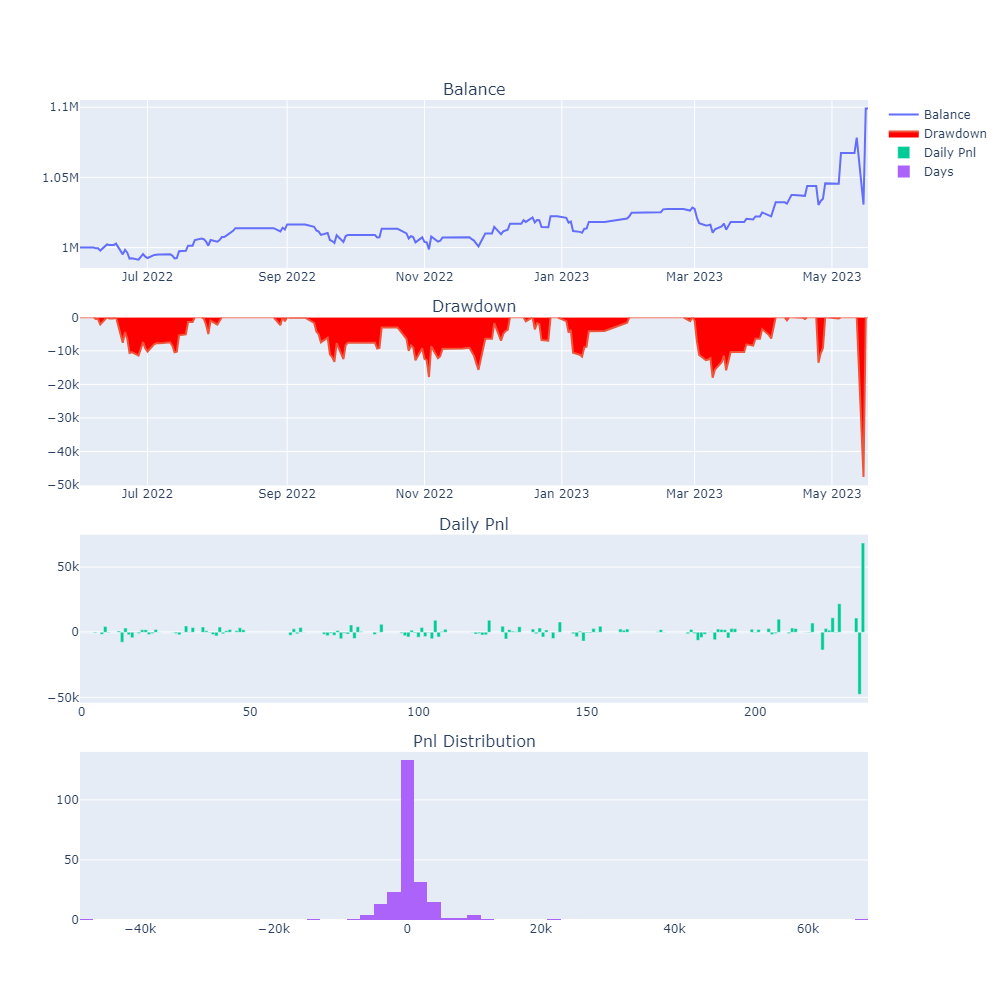

In [1]:
import datetime as dt

from vnpy_spreadtrading.backtesting import BacktestingEngine
from vnpy_spreadtrading.base import LegData, SpreadData
from vnpy_spreadtrading.strategies.statistical_arbitrage_strategy import StatisticalArbitrageStrategy

symbol1 = "m2305.DCE"
symbol2 = "RM305.CZCE"
spread = SpreadData(
    name = "spreadtrading",
    legs = [LegData(symbol1), LegData(symbol2)],
    variable_symbols = {"A": symbol1, "B": symbol2},
    variable_directions={"A":1, "B":-1},
    price_formula = "A-B",
    trading_multipliers = {symbol1: 1, symbol2: 1},
    active_symbol= symbol2,
    min_volume = 1
)
rate = 0.0001
engine = BacktestingEngine()
engine.set_parameters(
    spread = spread,
    interval = "1m",
    start = dt.datetime(2022, 5, 1),
    end = dt.datetime(2023, 6, 1),
    rate = rate,
    slippage = 1,
    size = 10,
    pricetick = 1,
    capital = 1_000_000,
)

setting = {
    "boll_window": 20*60*4,
    "boll_dev":2,
    "max_pos": 20,
    "payup": 10,
    "interval": 5
}

engine.add_strategy(StatisticalArbitrageStrategy,setting)

engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()


StatisticalArbitrageStrategy最大的问题是缺乏应对行情的灵活度。  

从成交数据中可以看出，该策略的成交量是不大的。当行情价差离开均线boll_dev个标准差时，策略会发出逆势交易信号，但是行情如果进一步偏离均线后，该策略没有后续操作，显然是缺乏操作性。

因此在这个默认版本基础上稍作修改，以z_score为指标，做一个类网格策略。

PS: z_score = (close_price - ma_value)/ standard deviation

In [ ]:
# zscore_grid_strategy.py

from math import floor, ceil

from vnpy.trader.utility import BarGenerator, ArrayManager
from vnpy_spreadtrading import (
    SpreadStrategyTemplate,
    SpreadAlgoTemplate,
    SpreadData,
    OrderData,
    TradeData,
    TickData,
    BarData
)


class ZscoreGridStrategy(SpreadStrategyTemplate):
    """"""

    author = "BrianL"

    ma_window = 20
    volume_multiplier = 5 # 每一格开仓手数
    max_pos = 25
    payup = 10
    interval = 5

    ma_value = 0.0
    z_score = 0.0
    spread_pos = 0.0

    parameters = [
        "ma_window",
        "volume_multiplier",
        "max_pos",
        "payup",
        "interval",
    ]
    variables = [
        "ma_value",
        "z_score",
        "spread_pos",
    ]

    def __init__(
        self,
        strategy_engine,
        strategy_name: str,
        spread: SpreadData,
        setting: dict
    ):
        """"""
        super().__init__(strategy_engine, strategy_name, spread, setting)

        self.bg = BarGenerator(self.on_spread_bar)
        self.am = ArrayManager(self.ma_window + 10)

    def on_init(self):
        """
        Callback when strategy is inited.
        """
        self.write_log("策略初始化")

        self.load_bar(10)

    def on_start(self):
        """
        Callback when strategy is started.
        """
        self.write_log("策略启动")

    def on_stop(self):
        """
        Callback when strategy is stopped.
        """
        self.write_log("策略停止")
    def on_spread_data(self):
        """
        Callback when spread price is updated.
        """
        tick = self.get_spread_tick()
        self.on_spread_tick(tick)

    def on_spread_tick(self, tick: TickData):
        """
        Callback when new spread tick data is generated.
        """
        self.bg.update_tick(tick)

    def on_spread_bar(self, bar: BarData):
        """"""
        self.am.update_bar(bar)
        if not self.am.inited or not self.trading:
            return
        
        # 撤销之前的挂单
        self.stop_all_algos()

        # 计算当前 z_score
        self.ma_value = self.am.sma(self.ma_window)
        self.price_change = bar.close_price - self.ma_value
        self.std = self.am.std(self.ma_window)
        self.z_score = self.price_change / self.std

        # 超价委托
        long_price = bar.close_price * 1.01
        short_price = bar.close_price * 0.99

        # 如果价格穿越均线全部平仓，详见图解1
        if self.spread_pos > 0 and self.price_change >= 0:
            self.start_short_algo(
                short_price,
                abs(self.spread_pos),
                payup=self.payup,
                interval=self.interval
            )
        # 详见图解2
        elif self.spread_pos < 0 and self.price_change <= 0:
            self.start_long_algo(
                long_price,
                abs(self.spread_pos),
                payup=self.payup,
                interval=self.interval
            )
        # 若无持仓则判断条件是否开仓，# 详见图解3
        else:
            if self.price_change > (0 + self.std):
                target_pos = -floor(self.z_score - 1) * self.volume_multiplier
                target_pos = max(-self.max_pos, target_pos)

                if target_pos < self.spread_pos:
                    self.start_short_algo(
                        short_price,
                        abs(target_pos - self.spread_pos),
                        payup=self.payup,
                        interval=self.interval
                    )
            # 详见图解4
            elif self.price_change < (0 - self.std):
                target_pos = -ceil(self.z_score + 1) * self.volume_multiplier
                target_pos = min(self.max_pos, target_pos)
                if target_pos > self.spread_pos:
                    self.start_long_algo(
                        long_price,
                        abs(target_pos - self.spread_pos),
                        payup=self.payup,
                        interval=self.interval
                    )
        
        # 更新图形界面
        self.put_event()

    def on_spread_pos(self):
        """
        Callback when spread position is updated.
        """
        self.spread_pos = self.get_spread_pos()
        self.put_event()

    def on_spread_algo(self, algo: SpreadAlgoTemplate):
        """
        Callback when algo status is updated.
        """
        pass

    def on_order(self, order: OrderData):
        """
        Callback when order status is updated.
        """
        pass

    def on_trade(self, trade: TradeData):
        """
        Callback when new trade data is received.
        """
        pass


<img src="9-1.png" width=600>

In [ ]:
import datetime as dt

from vnpy_spreadtrading.backtesting import BacktestingEngine
from vnpy_spreadtrading.base import LegData, SpreadData
#from vnpy_spreadtrading.strategies.statistical_arbitrage_strategy import StatisticalArbitrageStrategy
from zscore_grid_strategy import ZscoreGridStrategy
symbol1 = "m2305.DCE"
symbol2 = "RM305.CZCE"
spread = SpreadData(
    name = "spreadtrading",
    legs = [LegData(symbol1), LegData(symbol2)],
    variable_symbols = {"A": symbol1, "B": symbol2},
    variable_directions={"A":1, "B":-1},
    price_formula = "A-B",
    trading_multipliers = {symbol1: 1, symbol2: 1},
    active_symbol= symbol2,
    min_volume = 1
)
rate = 0.0001
engine = BacktestingEngine()
engine.set_parameters(
    spread = spread,
    interval = "1m",
    start = dt.datetime(2022, 5, 1),
    end = dt.datetime(2023, 6, 1),
    rate = rate,
    slippage = 1,
    size = 10,
    pricetick = 1,
    capital = 1_000_000,
)

setting = {
    "ma_window": 20*60*4,
    "max_pos": 5,
    "payup": 10,
    "interval": 5
}

engine.add_strategy(ZscoreGridStrategy,setting)

engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()


设置ZscoreGridStrategy 最大仓位max_pos为5，其余条件与StatisticalArbitrageStrategy一致，两者结果相同，则新修改的策略编写没有问题。

此处由于篇幅限制，就不做运行输出了。

增加max_pos设置，即允许策略浮亏加仓，看看成果如何。

2023-09-22 14:21:26.930398	开始加载历史数据
2023-09-22 14:21:34.854321	历史数据加载完成，数据量：82995
2023-09-22 14:21:34.877831	策略初始化完成
2023-09-22 14:21:34.877831	开始回放历史数据
2023-09-22 14:21:36.470597	历史数据回放结束
2023-09-22 14:21:36.470597	开始计算逐日盯市盈亏
2023-09-22 14:21:36.472600	逐日盯市盈亏计算完成
2023-09-22 14:21:36.474605	开始计算策略统计指标
2023-09-22 14:21:36.477612	------------------------------
2023-09-22 14:21:36.477612	首个交易日：	2022-06-01
2023-09-22 14:21:36.477612	最后交易日：	2023-05-17
2023-09-22 14:21:36.477612	总交易日：	234
2023-09-22 14:21:36.477612	盈利交易日：	80
2023-09-22 14:21:36.477612	亏损交易日：	67
2023-09-22 14:21:36.477612	起始资金：	1,000,000.00
2023-09-22 14:21:36.477612	结束资金：	1,034,583.82
2023-09-22 14:21:36.477612	总收益率：	3.46%
2023-09-22 14:21:36.477612	年化收益：	3.55%
2023-09-22 14:21:36.477612	最大回撤: 	-19,134.93
2023-09-22 14:21:36.477612	百分比最大回撤: -1.88%
2023-09-22 14:21:36.477612	最长回撤天数: 	3
2023-09-22 14:21:36.477612	总盈亏：	34,583.82
2023-09-22 14:21:36.477612	总手续费：	2,316.18
2023-09-22 14:21:36.477612	总滑点：	3,500.00
2023-09-22 14:21:

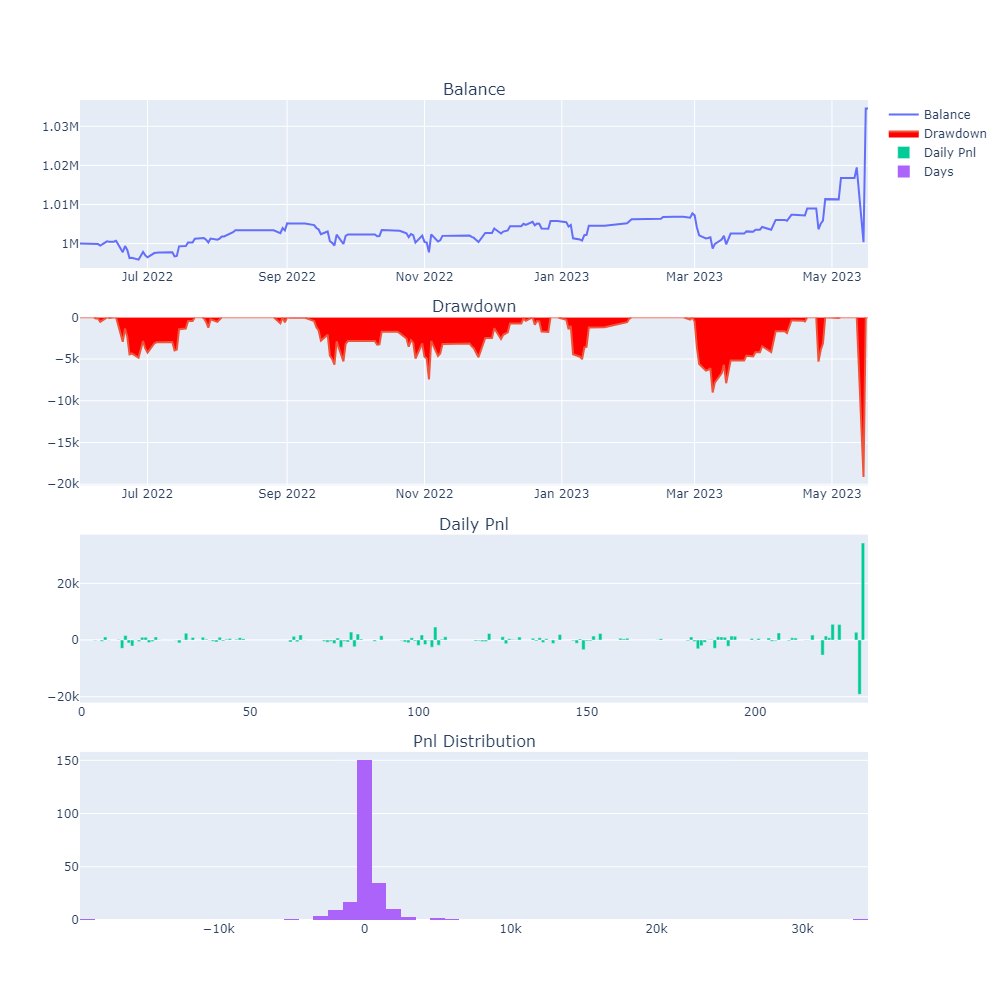

In [2]:
import datetime as dt

from vnpy_spreadtrading.backtesting import BacktestingEngine
from vnpy_spreadtrading.base import LegData, SpreadData
#from vnpy_spreadtrading.strategies.statistical_arbitrage_strategy import StatisticalArbitrageStrategy
from zscore_grid_strategy import ZscoreGridStrategy
symbol1 = "m2305.DCE"
symbol2 = "RM305.CZCE"
spread = SpreadData(
    name = "spreadtrading",
    legs = [LegData(symbol1), LegData(symbol2)],
    variable_symbols = {"A": symbol1, "B": symbol2},
    variable_directions={"A":1, "B":-1},
    price_formula = "A-B",
    trading_multipliers = {symbol1: 1, symbol2: 1},
    active_symbol= symbol2,
    min_volume = 1
)
# spread = SpreadData(
#     name = "spreadtrading",
#     legs = [LegData("m2305.DCE"), LegData("RM305.CZCE")],
#     variable_symbols = {"A": "m2305.DCE", "B": "RM305.CZCE"},
#     variable_directions={"A":1, "B":-1},
#     price_formula = "A-B",
#     trading_multipliers = {"m2305.DCE": 1, "RM305.CZCE": 1},
#     active_symbol= "RM305.CZCE",
#     min_volume = 1
# )
rate = 0.0001
engine = BacktestingEngine()
engine.set_parameters(
    spread = spread,
    interval = "1m",
    start = dt.datetime(2022, 5, 1),
    end = dt.datetime(2023, 6, 1),
    rate = rate,
    slippage = 1,
    size = 10,
    pricetick = 1,
    capital = 1_000_000,
)

setting = {
    "ma_window": 20*60*4,
    "max_pos": 10,
    "payup": 10,
    "interval": 5
}

engine.add_strategy(ZscoreGridStrategy,setting)

engine.load_data()
engine.run_backtesting()
df = engine.calculate_result()
engine.calculate_statistics()
engine.show_chart()


结果显示允许加仓一次的情况下，sharpe ratio出现下滑，并没有起到正向作用。

但这并不代表加仓策略失效，以上显示的是zscore>2时开仓，zscore每增加个标准差便增仓一手。

从参数优化的角度上考虑，zscore的开仓点取多少合适，每隔多少个标准差增仓合适，这些都是未知数。

因此，这个问题可以留给感兴趣的朋友自行探索。

同时，这里要提示的一点是，网格策略最担忧的情况就是出现连续极端行情，导致出现单次大幅亏损，本节演示代码并没有对此作出限制，因此千万不要直接拿来跑实盘，

本节演示代码仅供学习参考使用，如有不明白的地方可以留言或私信，谢谢。